<a href="https://colab.research.google.com/github/yashbelhe/11785-Adversarial-Detection/blob/master/Adversarial_Black_Box.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#PyTorch CIFAR10 ResNet 20 Implementation
https://github.com/akamaster/pytorch_resnet_cifar10

In [0]:
!git clone https://github.com/akamaster/pytorch_resnet_cifar10

Cloning into 'pytorch_resnet_cifar10'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 76 (delta 3), reused 6 (delta 2), pack-reused 65
Unpacking objects: 100% (76/76), done.
fatal: destination path 'pytorch_resnet_cifar10' already exists and is not an empty directory.


In [0]:
!wget https://github.com/akamaster/pytorch_resnet_cifar10/raw/master/pretrained_models/resnet20-12fca82f.th

--2019-11-08 18:15:31--  https://github.com/akamaster/pytorch_resnet_cifar10/raw/master/pretrained_models/resnet20-12fca82f.th
Resolving github.com (github.com)... 140.82.118.3
Connecting to github.com (github.com)|140.82.118.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/akamaster/pytorch_resnet_cifar10/master/pretrained_models/resnet20-12fca82f.th [following]
--2019-11-08 18:15:31--  https://raw.githubusercontent.com/akamaster/pytorch_resnet_cifar10/master/pretrained_models/resnet20-12fca82f.th
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1099231 (1.0M) [application/octet-stream]
Saving to: ‘resnet20-12fca82f.th’

resnet20-12fca82f.t 100%[===================>]   1.05M  --.-KB/s    in 0.02s  

In [0]:
import argparse
import os
import shutil
import time

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [0]:
batch_size = 128
num_workers = 4
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(root='./data', train=True, transform=transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, 4),
        transforms.ToTensor(),
        normalize,
    ]), download=True),
    batch_size=batch_size, shuffle=True,
    num_workers=num_workers, pin_memory=True)

val_set = datasets.CIFAR10(root='./data', train=False, transform=transforms.Compose([
    transforms.ToTensor(),
    # normalize,
]))

val_loader = torch.utils.data.DataLoader(
    val_set,
    batch_size=128, shuffle=False,
    num_workers=num_workers, pin_memory=True)

0it [00:00, ?it/s]

170500096it [00:06, 26942844.38it/s]                               


Extracting ./data/cifar-10-python.tar.gz to ./data


In [0]:
from pytorch_resnet_cifar10.resnet import *

model = torch.nn.DataParallel(resnet20())
model.cuda()
checkpoint = torch.load('resnet20-12fca82f.th')
model.load_state_dict(checkpoint['state_dict'])
criterion = nn.CrossEntropyLoss().cuda()

In [0]:
!git clone https://github.com/cg563/simple-blackbox-attack.git
!mv simple-blackbox-attack simple_blackbox_attack

Cloning into 'simple-blackbox-attack'...
remote: Enumerating objects: 38, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 38 (delta 18), reused 25 (delta 9), pack-reused 0
Unpacking objects: 100% (38/38), done.


# SimBA - https://github.com/cg563/simple-blackbox-attack

In [0]:
import torch
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
import math
import random
import torch.nn.functional as F
import argparse
import os
import pdb
from simple_blackbox_attack import utils

/usr/local/lib/python3.6/dist-packages/torchvision/transforms/transforms.py:211: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


In [0]:
def expand_vector(x, size):
    batch_size = x.size(0)
    x = x.view(-1, 3, size, size)
    z = torch.zeros(batch_size, 3, image_size, image_size)
    z[:, :, :size, :size] = x
    return z

# def normalize(x):
#     return utils.apply_normalization(x, 'imagenet')

def get_probs(model, x, y):
    output = model(torch.autograd.Variable(x.cuda())).cpu()
    probs = torch.index_select(torch.nn.Softmax()(output).data, 1, y)
    return torch.diag(probs)

def get_preds(model, x):
    output = model(torch.autograd.Variable(x.cuda())).cpu()
    _, preds = output.data.max(1)
    return preds

# runs simba on a batch of images <images_batch> with true labels (for untargeted attack) or target labels
# (for targeted attack) <labels_batch>
def dct_attack_batch(model, images_batch, labels_batch, max_iters, freq_dims, stride, epsilon, order='rand', targeted=False, pixel_attack=False, log_every=1):
    batch_size = images_batch.size(0)
    image_size = images_batch.size(2)
    # sample a random ordering for coordinates independently per batch element
    if order == 'rand':
        indices = torch.randperm(3 * freq_dims * freq_dims)[:max_iters]
    elif order == 'diag':
        indices = utils.diagonal_order(image_size, 3)[:max_iters]
    elif order == 'strided':
        indices = utils.block_order(image_size, 3, initial_size=freq_dims, stride=stride)[:max_iters]
    else:
        indices = utils.block_order(image_size, 3)[:max_iters]
    if order == 'rand':
        expand_dims = freq_dims
    else:
        expand_dims = image_size
    n_dims = 3 * expand_dims * expand_dims

    # amount of perturbation for each image along each axis
    x = torch.zeros(batch_size, n_dims)
    
    # logging tensors
    adv_images = torch.zeros_like(images_batch)
    probs = torch.zeros(batch_size, max_iters)
    succs = torch.zeros(batch_size, max_iters)
    queries = torch.zeros(batch_size, max_iters)
    l2_norms = torch.zeros(batch_size, max_iters)
    linf_norms = torch.zeros(batch_size, max_iters)
    # get the original correct classification probabilites
    prev_probs = get_probs(model, images_batch, labels_batch)
    # get the model predctions for the data (i.e the original labels) because we
    # only keep correctly classified images
    preds = get_preds(model, images_batch)

    # do a pixel by pixel attack or a DCT attack
    if pixel_attack:
        trans = lambda z: z
    else:
        trans = lambda z: utils.block_idct(z, block_size=image_size)
    
    remaining_indices = torch.arange(0, batch_size).long()
    
    for k in range(max_iters):
        # dimension to perform the attack along
        dim = indices[k]
        
        # Sum of images and x (compressed perturbation vector)
        # expand_vector takes x (batch_size, n_dims) to (batch_size, 3, freq_dim, freq_dim)
        # trans computes the inverse DCT of this vector
        expanded = (images_batch[remaining_indices] + trans(expand_vector(x[remaining_indices], expand_dims))).clamp(0, 1)
        
        #
        perturbation = trans(expand_vector(x, expand_dims))
        
        # L2 Norm of the perturbation
        l2_norms[:, k] = perturbation.view(batch_size, -1).norm(2, 1)
        # L-Infinity Norm of the perturbation
        linf_norms[:, k] = perturbation.view(batch_size, -1).abs().max(1)[0]
        preds_next = get_preds(model, expanded)
        preds[remaining_indices] = preds_next
        adv_images[remaining_indices] = expanded

        if targeted:
            remaining = preds.ne(labels_batch)
        else:
            remaining = preds.eq(labels_batch)
        # check if all images are misclassified and stop early
        if remaining.sum() == 0:
            adv = (images_batch + trans(expand_vector(x, expand_dims))).clamp(0, 1)
            probs_k = get_probs(model, adv, labels_batch)
            probs[:, k:] = probs_k.unsqueeze(1).repeat(1, max_iters - k)
            succs[:, k:] = torch.ones(batch_size, max_iters - k)
            queries[:, k:] = torch.zeros(batch_size, max_iters - k)
            break
        remaining_indices = torch.arange(0, batch_size)[remaining].long()
        if k > 0:
            succs[:, k-1] = ~remaining
        diff = torch.zeros(remaining.sum(), n_dims)
        diff[:, dim] = epsilon
        left_vec = x[remaining_indices] - diff
        right_vec = x[remaining_indices] + diff
        # trying negative direction
        adv = (images_batch[remaining_indices] + trans(expand_vector(left_vec, expand_dims))).clamp(0, 1)
        left_probs = get_probs(model, adv, labels_batch[remaining_indices])
        queries_k = torch.zeros(batch_size)
        # increase query count for all images
        queries_k[remaining_indices] += 1
        if targeted:
            improved = left_probs.gt(prev_probs[remaining_indices])
        else:
            improved = left_probs.lt(prev_probs[remaining_indices])
        # only increase query count further by 1 for images that did not improve in adversarial loss
        if improved.sum() < remaining_indices.size(0):
            queries_k[remaining_indices[~improved]] += 1
        
        # try positive directions
        adv = (images_batch[remaining_indices] + trans(expand_vector(right_vec, expand_dims))).clamp(0, 1)
        right_probs = get_probs(model, adv, labels_batch[remaining_indices])
        if targeted:
            right_improved = right_probs.gt(torch.max(prev_probs[remaining_indices], left_probs))
        else:
            right_improved = right_probs.lt(torch.min(prev_probs[remaining_indices], left_probs))
        probs_k = prev_probs.clone()
        # update x depending on which direction improved
        if improved.sum() > 0:
            left_indices = remaining_indices[improved]
            left_mask_remaining = improved.unsqueeze(1).repeat(1, n_dims)
            x[left_indices] = left_vec[left_mask_remaining].view(-1, n_dims)
            probs_k[left_indices] = left_probs[improved]
        if right_improved.sum() > 0:
            right_indices = remaining_indices[right_improved]
            right_mask_remaining = right_improved.unsqueeze(1).repeat(1, n_dims)
            x[right_indices] = right_vec[right_mask_remaining].view(-1, n_dims)
            probs_k[right_indices] = right_probs[right_improved]
        probs[:, k] = probs_k
        queries[:, k] = queries_k
        prev_probs = probs[:, k]
        if (k + 1) % log_every == 0 or k == max_iters - 1:
            print('Iteration %d: queries = %.4f, prob = %.4f, remaining = %.4f' % (
                    k + 1, queries.sum(1).mean(), probs[:, k].mean(), remaining.float().mean()))
    expanded = (images_batch + trans(expand_vector(x, expand_dims))).clamp(0, 1)
    preds = get_preds(model, expanded)
    if targeted:
        remaining = preds.ne(labels_batch)
    else:
        remaining = preds.eq(labels_batch)
    succs[:, max_iters-1] = ~remaining
    return x, probs, succs, queries, l2_norms, linf_norms, adv_images

def utils_get_preds(model, inputs, dataset_name, batch_size=128):
    num_batches = int(math.ceil(inputs.size(0) / float(batch_size)))
    softmax = torch.nn.Softmax()
    all_preds, all_probs = None, None
    # transform = trans.Normalize(IMAGENET_MEAN, IMAGENET_STD)
    for i in range(num_batches):
        upper = min((i + 1) * batch_size, inputs.size(0))
        input = inputs[(i * batch_size):upper]
        input_var = torch.autograd.Variable(input.cuda(), volatile=True)
        output = softmax.forward(model.forward(input_var))
        prob, pred = output.max(1)
        prob = prob.data.cpu()
        pred = pred.data.cpu()
        if i == 0:
            all_probs = prob
            all_preds = pred
        else:
            all_probs = torch.cat((all_probs, prob), 0)
            all_preds = torch.cat((all_preds, pred), 0)
    return all_preds, all_probs


In [0]:

result_dir = 'save'
sampled_image_dir = 'save'

if not os.path.exists(result_dir):
    os.mkdir(result_dir)
if not os.path.exists(sampled_image_dir):
    os.mkdir(sampled_image_dir)

# load model and dataset
model.eval()


# Number of images
num_runs = 2048*4

image_size = 32
freq_dims = 32
stride = 7
epsilon = 0.2
order = 'rand'
targeted_attack = False
targeted = False
pixel_attack = False
log_every = 50
num_iters = 500
batch_size = 128
# load sampled images or sample new ones
# this is to ensure all attacks are run on the same set of correctly classified images
batchfile = '%s/images_%s_%d.pth' % (sampled_image_dir, 'resnet_20', num_runs)

# images - the set of images to compute perturbations for
# labels - the labels corresponding to those images
if os.path.isfile(batchfile):
    checkpoint = torch.load(batchfile)
    images = checkpoint['images']
    labels = checkpoint['labels']
else:
    images = torch.zeros(num_runs, 3, image_size, image_size)
    labels = torch.zeros(num_runs).long()
    # Initially none of the labels and preds are equal, this forces us to load
    # new images and labels for all indices
    preds = labels + 1
    while preds.ne(labels).sum() > 0:
        # Get those indices where preds != labels
        idx = torch.arange(0, images.size(0)).long()[preds.ne(labels)]
        # Get new images from the dataset for those indices
        for i in list(idx):
            images[i], labels[i] = val_set[random.randint(0, len(val_set) - 1)]
        # Update the predictions for all the previously incorrectly predicted images
        preds[idx], _ = utils_get_preds(model, images[idx], 'cifar', batch_size=batch_size)
    # Save the dataset of images that the model correctly classifies
    torch.save({'images': images, 'labels': labels}, batchfile)

if order == 'rand':
    n_dims = 3 * freq_dims * freq_dims
else:
    n_dims = 3 * image_size * image_size

# max_iters determines the maximum number of updates per image
if num_iters > 0:
    max_iters = int(min(n_dims, num_iters))
else:
    max_iters = int(n_dims)

# N: number of batches of images
N = int(math.floor(float(num_runs) / float(batch_size)))

# Compute the adversarial perturbations for each batch of images
for i in range(N):
    # Get the current batch of images
    upper = min((i + 1) * batch_size, num_runs)
    images_batch = images[(i * batch_size):upper]
    labels_batch = labels[(i * batch_size):upper]

    # replace true label with random target labels in case of targeted attack
    # This code may be incorrect because of the 1000 being hardcoded for imagenet?
    # Might have to change to num_classes for general datasets
    if targeted:
        labels_targeted = labels_batch.clone()
        while labels_targeted.eq(labels_batch).sum() > 0:
            labels_targeted = torch.floor(1000 * torch.rand(labels_batch.size())).long()
        labels_batch = labels_targeted
    
    # Run the attack for the current batch
    x, probs, succs, queries, l2_norms, linf_norms, adv_images = dct_attack_batch(
        model, images_batch, labels_batch, max_iters, freq_dims, stride, epsilon, order=order,
        targeted=targeted, pixel_attack=pixel_attack, log_every=log_every)
    
    # Concatenate the results
    if i == 0:
        all_vecs = x
        all_probs = probs
        all_succs = succs
        all_queries = queries
        all_l2_norms = l2_norms
        all_linf_norms = linf_norms
        all_adv_images = adv_images
    else:
        all_vecs = torch.cat([all_vecs, x], dim=0)
        all_probs = torch.cat([all_probs, probs], dim=0)
        all_succs = torch.cat([all_succs, succs], dim=0)
        all_queries = torch.cat([all_queries, queries], dim=0)
        all_l2_norms = torch.cat([all_l2_norms, l2_norms], dim=0)
        all_linf_norms = torch.cat([all_linf_norms, linf_norms], dim=0)
        all_adv_images = torch.cat([all_adv_images, adv_images], dim=0)
    
    # Save results in a .pth in the directory `save`
    if pixel_attack:
        prefix = 'pixel'
    else:
        prefix = 'dct'
    if targeted:
        prefix += '_targeted'
    savefile = '%s/%s_%s_%d_%d_%d_%.4f_%s.pth' % (
        result_dir, prefix, 'resnet_20', num_runs, num_iters, freq_dims, epsilon, order)
    torch.save({'original': images, 'vecs': all_vecs, 'probs': all_probs, 'succs': all_succs, 'queries': all_queries,
                'l2_norms': all_l2_norms, 'linf_norms': all_linf_norms, 'adv_images': all_adv_images}, savefile)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:160: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


Iteration 50: queries = 39.5391, prob = 0.4867, remaining = 0.1641
Iteration 100: queries = 46.3750, prob = 0.4409, remaining = 0.0391
Iteration 150: queries = 47.9609, prob = 0.4308, remaining = 0.0078
Iteration 200: queries = 48.7422, prob = 0.4308, remaining = 0.0078
Iteration 250: queries = 49.5234, prob = 0.4308, remaining = 0.0078
Iteration 300: queries = 50.3047, prob = 0.4308, remaining = 0.0078
Iteration 350: queries = 51.0859, prob = 0.4308, remaining = 0.0078
Iteration 400: queries = 51.8672, prob = 0.4308, remaining = 0.0078
Iteration 450: queries = 52.6484, prob = 0.4308, remaining = 0.0078
Iteration 500: queries = 53.4297, prob = 0.4308, remaining = 0.0078
Iteration 50: queries = 47.1641, prob = 0.5407, remaining = 0.3047
Iteration 100: queries = 59.1875, prob = 0.4502, remaining = 0.0781
Iteration 150: queries = 62.2734, prob = 0.4298, remaining = 0.0078
Iteration 50: queries = 44.5391, prob = 0.5327, remaining = 0.3047
Iteration 100: queries = 55.0078, prob = 0.4370, re

In [0]:
# checkpoint_load = torch.load('save/images_resnet_20_128.pth')
checkpoint_load = torch.load('save/dct_resnet_20_8192_500_32_0.2000_rand.pth')
# checkpoint_load = torch.load('save/pixel_resnet_20_3000_500_32_0.2000_rand.pth')

# checkpoint_load = torch.load('save/dct_resnet_20_128_500_32_0.2000_rand.pth')



In [0]:
import scipy
def dct2(a):
    return scipy.fftpack.dct( scipy.fftpack.dct( a, axis=1, norm='ortho' ), axis=2, norm='ortho' )

def idct2(a):
    return scipy.fftpack.idct( scipy.fftpack.idct( a, axis=1 , norm='ortho'), axis=2 , norm='ortho')

Number of images are
8192


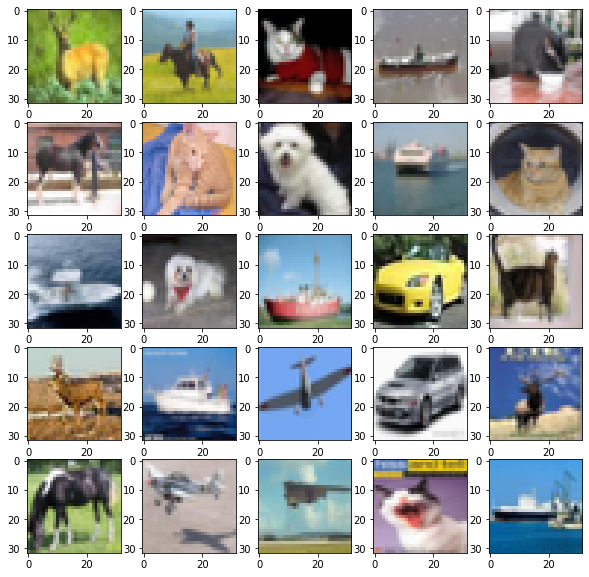

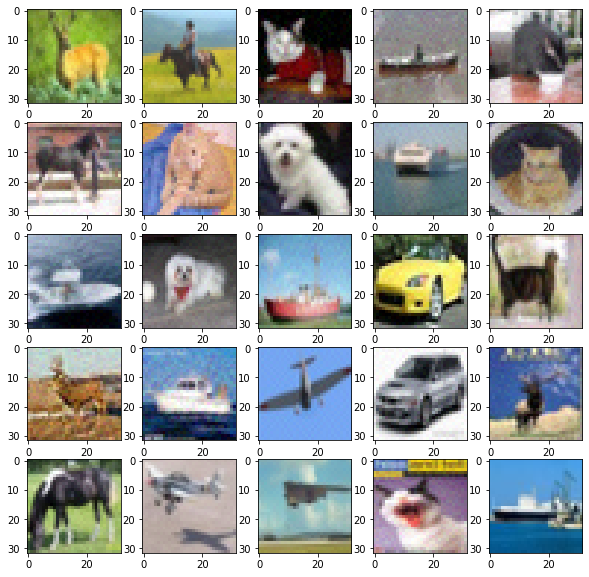

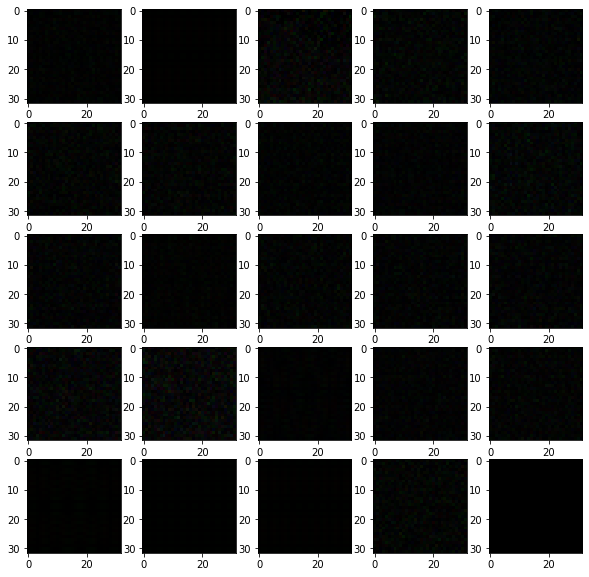

In [0]:
# torch.save({'original': images, 'vecs': all_vecs, 'probs': all_probs, 'succs': all_succs, 'queries': all_queries,
# l2_norms': all_l2_norms, 'linf_norms': all_linf_norms}, savefile)
# normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                      std=[0.229, 0.224, 0.225])
import matplotlib.pyplot as plt
%matplotlib inline

# from IPython.display import display
# from PIL import Image, ImageDraw
# import torchvision
# to_pil = torchvision.transforms.ToPILImage()


# mean = torch.Tensor([0.485, 0.456, 0.406])
# stddev = torch.Tensor([0.229, 0.224, 0.225])
original = checkpoint_load['original']
adv_image = checkpoint_load['adv_images']
print("Number of images are")
print(original.shape[0])
# print(abs(original-adv_image).mean())
# print(adv_image.min())
# adv_image = adv_images * stddev.view(1,3,1,1) + mean.view(1,3,1,1)

N = 5

plt.figure(1, figsize=(10, 10))
# plt.title('Original Images')
for i in range(N**2):
    plt.subplot(N, N, i + 1)
    plt.imshow(original[i].numpy().transpose(1,2,0))

plt.figure(2, figsize=(10, 10))
# plt.title('Adversarial Images')
for i in range(N**2):
    plt.subplot(N, N, i + 1)
    plt.imshow(adv_image[i].numpy().transpose(1,2,0))

plt.figure(3, figsize=(10, 10))
for i in range(N**2):
    plt.subplot(N, N, i + 1)
    plt.imshow(np.abs((original[i] - adv_image[i]).numpy()).transpose(1,2,0))


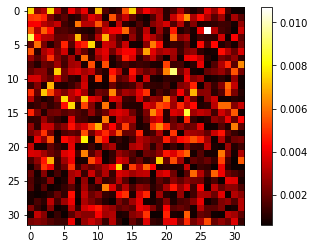

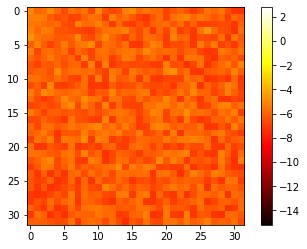

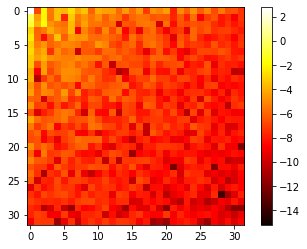

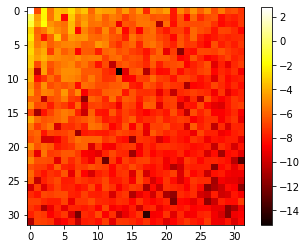

In [0]:
from matplotlib.colors import LogNorm

diff = np.zeros(original.shape[1:])
orig_avg = np.zeros(original.shape[1:])
adv_avg = np.zeros(original.shape[1:])
for i in range(original.shape[0]):
    # print(i)
    orig = original[i].numpy()
    adv = adv_image[i].numpy()

    orig_dct = dct2(orig)
    adv_dct = dct2(adv)

    diff += np.abs(orig_dct - adv_dct)
    orig_avg += orig_dct
    adv_avg += adv_dct

    # orig_rec = idct2(orig_dct)
    # adv_rec = idct2(adv_dct)

diff = diff / original.shape[0]
orig_avg = orig_avg / original.shape[0]
adv_avg = adv_avg / original.shape[0]
# img = to_pil(torch.Tensor(orig_rec))
# img = img.resize((128,128), Image.ANTIALIAS)
# display(img) 
# orig_dct.shape
# a = np.random.random((16, 16))

# Choose the channel across which to compute the DCT's
# 0 is red, 1 is green, 2 is blue
ch = 1

# Show the Heatmap of the Red Channel's DCT for the absolute difference
# This one is to show that the absolute differences are roughly equal for all frequencies
# which may not be easily interpretable in the log-domain.
plt.imshow(diff[ch], cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

# Make sure the scaling on the plots is the same
vmax = np.max([np.max(np.log(np.abs(orig_avg[ch]))), np.max(np.log(np.abs(adv_avg[ch])))])
vmin = np.min([np.min(np.log(np.abs(orig_avg[ch]))), np.min(np.log(np.abs(adv_avg[ch])))])

# Show the log of the Heatmap of the Red Channel's DCT for the absolute difference
plt.imshow(np.log(diff[ch]), cmap='hot', interpolation='nearest', vmin=vmin, vmax=vmax)
plt.colorbar()
plt.show()

# Show the log of the heatmap of the Red Channel's DCT for the Original Images
plt.imshow(np.log(np.abs(orig_avg[ch])), cmap='hot', interpolation='nearest', vmin=vmin, vmax=vmax)
plt.colorbar()
plt.show()

# Show the log of the heatmap of the Red Channel's DCT for the Perturbed Images
plt.imshow(np.log(np.abs(adv_avg[ch])), cmap='hot', interpolation='nearest', vmin=vmin, vmax=vmax)
plt.colorbar()
plt.show()

# plt.imshow(adv_dct[2], cmap='hot', interpolation='nearest')
# plt.show()
# display(orig_dct)

The DCT heatmaps (for the DCT Attack) seem to show that the adversarial perturbations affect almost all DCT components.  

This is of course to be expected because when constructing the attack we are choosing DCT directions uniformly at random and keeping them if they manage to reduce classification accuracy (which implies that all DCT directions manage to reduce classification accuracy on average).  

Next, we need to ensure the the DCT plots for different black-box attacks also show a similar structure (i.e they are uniformly distributed over all frequencies).

#Advertorch is a PyTorch library which has implemented a bunch of adversarial attacks.  
Here, we use the library to find the distribution of the perturbations in the DCT domain

In [0]:
!pip install advertorch

     |████████████████████████████████| 5.3MB 10.1MB/s 
  Created wheel for advertorch: filename=advertorch-0.1.5-cp36-none-any.whl size=5314098 sha256=f8f8c99161e44addcd61f6d903fb940c52ba4dd48168cbf54d7f8174fbfb6b6e
  Stored in directory: /root/.cache/pip/wheels/7f/c8/ee/0a9c753fb433ad244b41cb1ab5cf088fc856506f5f011bedb1
Successfully built advertorch


In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

import os
import argparse
import torch
import torch.nn as nn

from advertorch.utils import predict_from_logits
from advertorch_examples.utils import get_mnist_test_loader
from advertorch_examples.utils import _imshow

torch.manual_seed(0)
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")



In [0]:
# from advertorch.test_utils import LeNet5
# from advertorch_examples.utils import TRAINED_MODEL_PATH

# filename = "mnist_lenet5_clntrained.pt"
# # filename = "mnist_lenet5_advtrained.pt"

# model = LeNet5()
# model.load_state_dict(
#     torch.load(os.path.join(TRAINED_MODEL_PATH, filename)))
# model.to(device)
# model.eval()

In [0]:
# batch_size = 128
# # loader = get_mnist_test_loader(batch_size=batch_size)
# cln_data = None
# true_label = None
# for data, label in val_loader:
#     if cln_data is None:
#         cln_data = data
#         true_label = label
#     else:
#         cln_data = torch.cat([cln_data, data])
#         true_label = torch.cat([true_label, label])
# cln_data, true_label = cln_data.to(device), true_label.to(device)

In [0]:
from advertorch.attacks import LinfPGDAttack, GradientAttack

# adversary = LinfPGDAttack(
#     model, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=0.15,
#     nb_iter=40, eps_iter=0.01, rand_init=True, clip_min=0.0, clip_max=1.0,
#     targeted=False)

adversary = GradientAttack(
    model, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=0.3,
    clip_min=0.0, clip_max=1.0, targeted=False)

batch_size = 128
adv_untargeted = None
for cln_data, true_label in val_loader:
    cln_data, true_label = cln_data.to(device), true_label.to(device)
    output = adversary.perturb(cln_data, true_label)
    if adv_untargeted is None:
        adv_untargeted = output
    else:
        adv_untargeted = torch.cat([adv_untargeted, output])
        

# adv_untargeted = adversary.perturb(cln_data, true_label)

# target = torch.ones_like(true_label) * 3
# adversary.targeted = True
# adv_targeted = adversary.perturb(cln_data, target)

In [0]:
pred_cln = predict_from_logits(model(cln_data))
pred_untargeted_adv = predict_from_logits(model(adv_untargeted))
pred_targeted_adv = predict_from_logits(model(adv_targeted))

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
for ii in range(batch_size):
    plt.subplot(3, batch_size, ii + 1)
    _imshow(cln_data[ii])
    plt.title("clean \n pred: {}".format(pred_cln[ii]))
    plt.subplot(3, batch_size, ii + 1 + batch_size)
    _imshow(adv_untargeted[ii])
    plt.title("untargeted \n adv \n pred: {}".format(
        pred_untargeted_adv[ii]))
    plt.subplot(3, batch_size, ii + 1 + batch_size * 2)
    _imshow(adv_targeted[ii])
    plt.title("targeted to 3 \n adv \n pred: {}".format(
        pred_targeted_adv[ii]))

plt.tight_layout()
plt.show()



RuntimeError: ignored

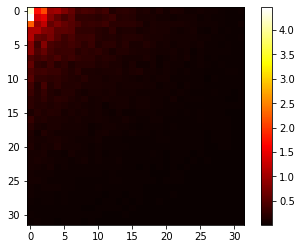

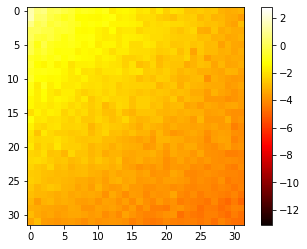

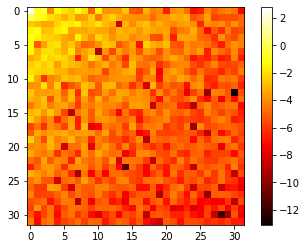

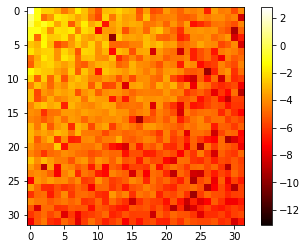

In [0]:
original = cln_data.detach().cpu()
adv_image = adv_untargeted.detach().cpu()

diff = np.zeros(original.shape[1:])
orig_avg = np.zeros(original.shape[1:])
adv_avg = np.zeros(original.shape[1:])
for i in range(original.shape[0]):
    # print(i)
    orig = original[i].numpy()
    adv = adv_image[i].numpy()

    orig_dct = dct2(orig)
    adv_dct = dct2(adv)

    diff += np.abs(orig_dct - adv_dct)
    orig_avg += orig_dct
    adv_avg += adv_dct

    # orig_rec = idct2(orig_dct)
    # adv_rec = idct2(adv_dct)

diff = diff / original.shape[0]
orig_avg = orig_avg / original.shape[0]
adv_avg = adv_avg / original.shape[0]

# Choose the channel across which to compute the DCT's
# 0 is red, 1 is green, 2 is blue
ch = 1

# Show the Heatmap of the Red Channel's DCT for the absolute difference
# This one is to show that the absolute differences are roughly equal for all frequencies
# which may not be easily interpretable in the log-domain.
plt.imshow(diff[ch], cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

# Make sure the scaling on the plots is the same
vmax = np.max([np.max(np.log(np.abs(orig_avg[ch]))), np.max(np.log(np.abs(adv_avg[ch])))])
vmin = np.min([np.min(np.log(np.abs(orig_avg[ch]))), np.min(np.log(np.abs(adv_avg[ch])))])

# Show the log of the Heatmap of the Red Channel's DCT for the absolute difference
plt.imshow(np.log(diff[ch]), cmap='hot', interpolation='nearest', vmin=vmin, vmax=vmax)
plt.colorbar()
plt.show()

# Show the log of the heatmap of the Red Channel's DCT for the Original Images
plt.imshow(np.log(np.abs(orig_avg[ch])), cmap='hot', interpolation='nearest', vmin=vmin, vmax=vmax)
plt.colorbar()
plt.show()

# Show the log of the heatmap of the Red Channel's DCT for the Perturbed Images
plt.imshow(np.log(np.abs(adv_avg[ch])), cmap='hot', interpolation='nearest', vmin=vmin, vmax=vmax)
plt.colorbar()
plt.show()